# Neural Networks Learning

In this practice, we are going to implement backpropagation for the task of hand-written digit recognition using neural network technique.

In [5]:
#import necessary packages

#manipulate directories
import os

#numerical vector and matrice manipulation and operation
import numpy as np

#numerical computation and optimization module 
import scipy.optimize as optimize

#used to load matlab files
from scipy.io import loadmat

#load matplotlib for visulization
import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline

# 1. Neural Network

In part 1, we are focusing on implementation of backpropagation algorithm to learn/train/update parameters to optimum values for the neural network

First, we will be loading the dataset and then processing the data.

In [6]:
#load data from provided matlab file format
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
#examine type of variable data
print('Type of variable ''data'':', type(data))
#check keys of dict obj data
print('Keys:', data.keys())

#load X, y into corresponding var X, y
X, y = data['X'], data['y'].flatten()
print("X's shape: ", X.shape, "\ny's shape:", y.shape)
#examine unique class labels stored in y
print('Class labels:', *np.unique(y))
#y is formatted in matlab with the first index as 1
#so we are going to set all class labels 10 into 0 as the proper first index in python
y[y==10] = 0

#number of features - n in input X, number of input images or examples - m
n, m = X.shape[1], y.size
print('# of features:', n, '\n# of training images:', m)

Type of variable data: <class 'dict'>
Keys: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
X's shape:  (5000, 400) 
y's shape: (5000,)
Class labels: 1 2 3 4 5 6 7 8 9 10
# of features: 400 
# of training images: 5000


### 1.1 Visualize the training data / images

In [133]:
def visualizeData(X, y=None, chosen_m=100, permutation=True, figsize=(10, 10)):
    '''
    Visualize m images from the training set
    
    Parameters:
    ---
    X: array-like
        The matrice that holds pixel intensity values of training images
    y: array-like
        The vector that store the ground truths or class labels 
    chosen_m: int
        number of images to visualize
    permutation: boolean
        Permutate the dataset before choosing sample for visualization
    figisze: tuple
        Height and width of the figure for plotting
        
    Returns:
    ---
    The plot of grids for m images
    '''
    
    #compute rows, cols
#     if X.ndim == 1:
#         m, n = 1, X.size
#         X = X[None]
#     elif X.ndim == 2:
#         m, n = X.shape
#     else:
#         raise ValueError('X should be of dimension 1-2')
    
    if permutation:
        rand_indices = np.random.permutation(chosen_m)[:chosen_m]
        X_permuted = X[rand_indices, :]
        y_permuted = y[rand_indices]

        #compute number of rows & cols in the grid plot of images
    nrows = np.int(np.sqrt(chosen_m))
    ncols = np.int(np.ceil(chosen_m / nrows))
    #plot figure of nrows, ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = [ax] if m == 1 or chosen_m == 1 else ax.flatten()
    fig.subplots_adjust(hspace=0.5)
    
    #for-loop to plot all chosen images
    for i, ax_ in enumerate(ax):
        ax_.imshow(X_permuted[i, :].reshape((20, 20), order='F'))
        ax_.axis('off')
        ax_.set_title('y = %d'%y_permuted[i], y=0, pad=-5, verticalalignment="top")

        

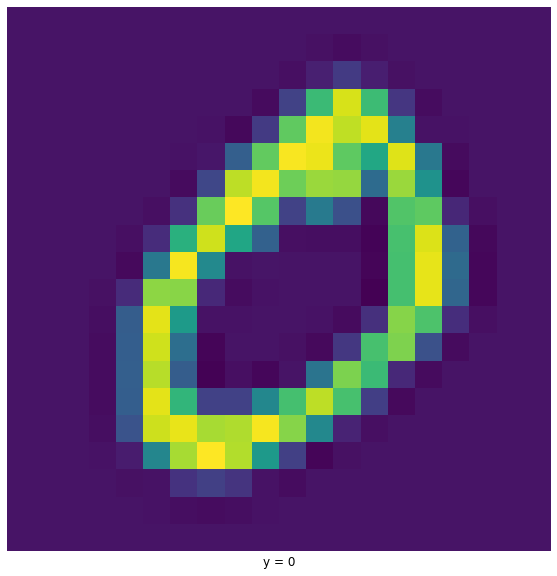

In [134]:
#visulize only 1 randomly selected example
visualizeData(X, y, chosen_m = 1)

### 1.2 Model Representation

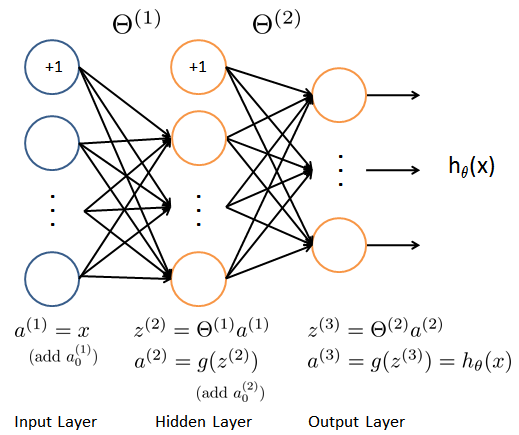
Suppose this is our neural network made up of 3 layers as the followings: 1 input, 1 hidden and 1 output. Each training image is of 20x20 pixels. So, our input feature vector belongs to 400-dimension. 

We are given the already trained parameters/weights ($\Theta^{(1)}, \Theta^{(2)}$) for the neural network from the matlab file in folder the Data. These 2 sets of paramets will be correspondingly loaded into `Theta1` and `Theta2`.

In [52]:
input_layer_size = 400 #20X20 input image
hidden_layer_size = 25 #25 activations of units/neurons/nodes in hidden layer
num_labels = 10 #10 output units represent 10 class labels, from 0 to 9

#load wegiths into theta1, theta2
weights = loadmat(os.path.join('Data', 'ex4weights.mat'))
print('Keys:', weights.keys())
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
print('Theta 1:', Theta1.shape)
print('Theta 2:', Theta2.shape)
Theta2 = np.roll(Theta2, 1, axis=0)

#unrol paramters
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()], axis=0)

print('nn_params:', len(nn_params))

Keys: dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])
Theta 1: (25, 401)
Theta 2: (10, 26)
nn_params: 10285


### 1.3 Feedforward Propagation & Cost Function

We will define function nnCostFunction to calculate the cost of our neural network

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit.

Also note that we need to encode label y as vectors including only 0's and 1's according to one-hot encoding in one-vs-all classification. 

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ has the ground truth of digit 5, then the corresponding $y{(i)}$ would be a 10-dimensional vector with the $5^{th}$ element = 1 and the rest = 0

The cost function for neural networks with regularization is given by:


$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

In [53]:
#sigmoid function
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

In [89]:
#regularized neural network cost function
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    """
    #reshape nn_params back into Theta1 & Theta2 as the weights
    #for our first and second layer
    Theta1 = nn_params[:(input_layer_size + 1) * hidden_layer_size].reshape(
        hidden_layer_size, input_layer_size + 1)
    Theta2 = nn_params[(input_layer_size + 1) * hidden_layer_size:].reshape(
        num_labels, hidden_layer_size + 1)

    #encode label y from a vector into a matrix with each row as a vector of 0 and 1 representing the label yi for xi
    #we do it in 2 way
    ##indexing an size-m identity metrid
    y_dummy = np.eye(num_labels)[y]
    ##use pd.get_dummies
    # y_encoded = pd.get_dummies(y)
    # np.mean(y_dummy == y_encoded.values) ## 1.0
    m, n = X.shape
    #cost
    J = 0
    #initialize gradients of theta1 & theta2
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    #add bias terms = 1 to X
    X = np.c_[np.ones((m, 1)), X]
    #hiden layer or layer 2
    z2 = X @ Theta1.T
    a2 = sigmoid(z2)
    #output layer
    #add intercept term to a2
    a2 = np.hstack([np.ones((m, 1)), a2])
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)

    #Cost computation
    J = (-1 / m) * np.sum(y_dummy * np.log(a3) +
                          (1 - y_dummy) * np.log(1 - a3)) + lambda_ / (2 * m) * (
                              np.sum(np.square(Theta1[:, 1:])) +
                              np.sum(np.square(Theta2[:, 1:])))
    #next we are going to calculate partial derivative of cost function 
    #with respect to Theta matrices added with regularization term
    ##error of nodes in output layer
    d3 = a3 - y_dummy
    ##eror of nodes in hidden layer
    d2 = d3 @ Theta2[:, 1:]  * a2[:, 1:] * (1 - a2[:, 1:])
    #partial derivate of cost with respect to Thetas + regularization term for parameters + non-bias nodes
    theta1_grad = (1 / m) * (d2.T @ X + lambda_ * np.c_[np.zeros((hidden_layer_size, 1)), Theta1[:, 1:]])
    theta2_grad = (1 / m) * (d3.T @ a2 + lambda_ * np.c_[np.zeros((num_labels, 1)), Theta2[:, 1:]])
    #unroll theta1_grad, theta_2grad into grad
    grad = np.r_[theta1_grad.flatten(), theta2_grad.flatten()]
    return J, grad

In [90]:
#TEST COST WITHOUT REGULARIZATION
lambda_ = 0
J, _= nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')

Cost at parameters (loaded from ex4weights): 3.267318 
The cost should be about                   : 0.287629.


In [91]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 3.267896
This value should be about                 : 0.383770.


### 1.4 Back Propagation

The next part would be about implementation of backpropagation in order to learn for the optimum parameters. We are going to constantly update `nnCostFunction` so that it returns an appropriate value for grad. Next we are going to employ `scipy.optimize.minimize` to train the neural network for the purpose of <b>J($\theta$)</b> or <b>Cost</b> minimization.

#### 1.4.1 Sigmoid Gradient

Now, we are creating a function to return the derivative or gradient of sigmoid function with respect to input z (which is the weighted sum of the previous-layer inputs $z^{(l)}$ = $\theta^{(l - 1)}$.$T$ * $a^{(l - 1)}$

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

In [92]:
def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z. 
    This should work regardless if z is a matrix or a vector. 
    In particular, if z is a vector or matrix, you should return
    the gradient for each element.
    
    Parameters
    ----------
    z : array_like
        A vector or matrix as input to the sigmoid function. 
    
    Returns
    --------
    g : array_like
        Gradient of the sigmoid function. Has the same shape as z. 
    """
    g = np.zeros(z.shape)
    
    g = sigmoid(z) * (1 - sigmoid(z))
    
    return g

After this, we will test our `sigmoidGradient` function given a vector z. Please not that for the large magnitue of z, the gradient will be very close to 0. When z =0, the gradient is exactly 0.25.

In [93]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


#### 1.4.2 Random Initialization

When training a neural network, it is essential it select random initial values for the weights or thetas for symmetry breaking. A good strategy would be to uniformly choose these values within the range [$-\epsilon_{init}$, $\epsilon_{init}$].

<div class="alert alert-box alert-warning">
One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$.
</div>


For simplicaity, in this task we choose $\epsilon_{init}$ = 0.12

In [94]:
#define function to randomly intilize weight matrices in the given epsilon range
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.
    
    Parameters
    ----------
    L_in : int
        Number of incomming connections.
    
    L_out : int
        Number of outgoing connections. 
    
    epsilon_init : float, optional
        Range of values which the weight can take from a uniform 
        distribution.
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
    """
    return np.random.rand(L_out, L_in + 1) * 2 * epsilon_init - epsilon_init

In [95]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


#### 1.4.3 BackPropagation

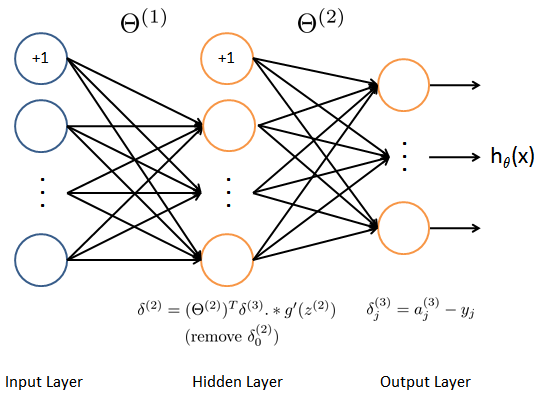

![](Figures/ex4-backpropagation.png)

Now, we will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, we will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$. In detail, here is the backpropagation algorithm (also depicted in the figure above). We should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, we should implement a for-loop `for t in range(m)` and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that we need to add a `+1` term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In `numpy`, if a 1 is a column matrix, adding one corresponds to `a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

1. For each output unit $k$ in layer 3 (the output layer), set 
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. We may find logical arrays helpful for this task (explained in the previous programming exercise).

1. For the hidden layer $l = 2$, set 
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Note that the symbol $*$ performs element wise multiplication in `numpy`.

1. Accumulate the gradient from this example using the following formula. Note that we should skip or remove $\delta_0^{(2)}$. In `numpy`, removing $\delta_0^{(2)}$ corresponds to `delta_2 = delta_2[1:]`.
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} (a^{(l)})^{(T)} $$

1. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

#### 1.4.4 Numberical Gradient Computation / Gradient Checking

In our neural network, we are minimizing the cost function $J(\Theta)$. To perform gradient checking on our parameters, we can imagine “unrolling” the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. By doing so, we can think of the cost function being $J(\Theta)$ instead and use the following gradient checking procedure.

Suppose we have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; we’d like to check if $f_i$ is outputting correct derivative values.

$$
\text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i−)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. We can now numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4}$, we’ll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

We have implemented the function to compute the numerical gradient for we in `computeNumericalGradient` (within the file `utils.py`). While we are not required to modify the file, we highly encourage we to take a look at the code to understand how it works.

In the next cell we will run the provided function `checkNNGradients` which will create a small neural network and dataset that will be used for checking our gradients. If our backpropagation implementation is correct,
we should see a relative difference that is less than 1e-9.


In [96]:
def computeNumericalGradient(J, theta, epsilon=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.

    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.

    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.

    e : float (optional)
        The value to use for epsilon for computing the finite difference.
    Return
    ----------
    approxGradient: array_like
        Numerically approximated gradients of cost function with repsect to theta
    """
    epsilon_mat = np.eye(theta.size) * epsilon
    approxGradient = np.zeros(theta.shape)
    for i in range(theta.size):
        approxGradient[i] = (J(theta + epsilon_mat[i])[0] - J(theta - epsilon_mat[i])[0]) / (2 * epsilon)
    return approxGradient

In [97]:
def debugInitializeWeights(fan_out, fan_in):
    """
    Initialize the weights of a layer with fan_in incoming connections and fan_out outgoings
    connections using a fixed strategy. This will help you later in debugging.

    Note that W should be set a matrix of size (1+fan_in, fan_out) as the first row of W handles
    the "bias" terms.

    Parameters
    ----------
    fan_out : int
        The number of outgoing connections.

    fan_in : int
        The number of incoming connections.

    Returns
    -------
    W : array_like (1+fan_in, fan_out)
        The initialized weights array given the dimensions.
    """
    # Initialize W using "sin". This ensures that W is always of the same values and will be
    # useful for debugging
    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    return W

In [98]:
def gradientChecking(nnCostFunction,
                     lambda_=0,
                     input_layer_size=3,
                     hidden_layer_size=5,
                     output_layer_size=3):
    """
    Creates a small neural network to check the backpropagation gradients. It will output the
    analytical gradients produced by your backprop code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result in
    very similar values.

    Parameters
    ----------
    nnCostFunction : func
        A reference to the cost function implemented by the student.

    lambda_ : float (optional)
        The regularization parameter value.
    """
    #randomly initialize W
    theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    theta2 = debugInitializeWeights(output_layer_size, hidden_layer_size)
    theta = np.concatenate([theta1.ravel(), theta2.ravel()])

    #dimension of input X
    m, n = 3, input_layer_size

    #randomly initialize X, y
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.arange(1, 1 + m) % 10 - 1
    #numerical gradient
    cost = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                    output_layer_size, X, y, lambda_)
    numGradient = computeNumericalGradient(cost, theta)
    grad = cost(theta)[1]
    #examine the two ways of calculating gradients
    #stack the 2 results into 2 columns in an array
    results = np.stack([numGradient, grad], axis=1)
    print(results)
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')

    #difference between 2 results
    diff = np.linalg.norm(numGradient -grad) / np.linalg.norm(grad)
    print(
        "In conclusion, our back prop algorithm works well",
        " due to the very small value of relative difference",
        " between gradients using numerical compuation and back propagatio"
    )
    return diff

In [99]:
gradientChecking(nnCostFunction)

[[-0.00881829 -0.00881829]
 [-0.00031487 -0.00031487]
 [ 0.00038391  0.00038391]
 [-0.00044527 -0.00044527]
 [ 0.00904312  0.00904312]
 [ 0.00039355  0.00039355]
 [-0.00044164 -0.00044164]
 [ 0.00048088  0.00048088]
 [-0.0091076  -0.0091076 ]
 [-0.00046543 -0.00046543]
 [ 0.00049164  0.00049164]
 [-0.00050802 -0.00050802]
 [ 0.00895794  0.00895794]
 [ 0.00052637  0.00052637]
 [-0.00053009 -0.00053009]
 [ 0.00052321  0.00052321]
 [-0.00863496 -0.00863496]
 [-0.00057695 -0.00057695]
 [ 0.00055817  0.00055817]
 [-0.00052822 -0.00052822]
 [ 0.18119734  0.18119734]
 [ 0.09450564  0.09450564]
 [ 0.09458584  0.09458584]
 [ 0.0910006   0.0910006 ]
 [ 0.08704509  0.08704509]
 [ 0.08635784  0.08635784]
 [ 0.17771082  0.17771082]
 [ 0.09261378  0.09261378]
 [ 0.09290088  0.09290088]
 [ 0.08946938  0.08946938]
 [ 0.08547223  0.08547223]
 [ 0.08458708  0.08458708]
 [ 0.16406822  0.16406822]
 [ 0.08574416  0.08574416]
 [ 0.08602727  0.08602727]
 [ 0.08263994  0.08263994]
 [ 0.07869433  0.07869433]
 

4.964437498561029e-11

# 2 Learning parameters using `scipy.optimize.minimize`

After having successfully implementing neural network cost function and gradient computation, next we will use scipy's minimization to achieve a good set of parameters

In [100]:
randInitializeWeights??

In [111]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
#number of iterations
options = {'maxiter': 100}
#lambda
lambda_ = 1.0
#theta initialization
Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_theta = np.concatenate([Theta1.flatten(), Theta2.flatten()])
#minimize cost func
minimizer = optimize.minimize(nnCostFunction, initial_theta, args=(input_layer_size, hidden_layer_size,
                                                                   num_labels, X, y, lambda_), jac=True, method='TNC', options=options)
#nn params
#cost
print(minimizer.fun)
#trained parameters
nn_params = minimizer.x
Theta1 = nn_params[: (input_layer_size + 1) * hidden_layer_size].reshape((hidden_layer_size, input_layer_size + 1))
Theta2 = nn_params[(input_layer_size + 1) * hidden_layer_size :].reshape((num_labels, hidden_layer_size + 1))

0.4698978927878078


In [123]:
def pred(X, Theta1, Theta2):
    X = np.c_[np.ones((X.shape[0], 1)), X]
    z2 = X @ Theta1.T
    a2 = sigmoid(z2)
    a2 = np.hstack([np.ones((a2.shape[0], 1)), a2])
    z3 = a2 @ Theta2.T
    z3 = sigmoid(z3)
    return np.argmax(z3, axis=1)
print('Training accuracy:%.2f%%'%(np.mean(pred(X, Theta1, Theta2)==y)*100))

Training accuracy:95.86%


In [130]:
y

array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In [132]:
Theta1[:, 1:].shape

(25, 400)

In [135]:
visualizeData(Theta1[:, 1:], y=None)

IndexError: index 63 is out of bounds for axis 0 with size 25